## Lab4: Introduction to Convolutional Layers

Author: Aakash Kaku, Lee Tanenbaum

The goal of this lab is to understand how to train a convolutional neural network using PyTorch. A lot of starter code will be given to you, and the student is expected to build the network details.

The dataset we will analyze will be a small section of the nih chest xrays dataset, found here: https://www.kaggle.com/nih-chest-xrays/sample . Please create a Kaggle account to download the data (or access in a class folder if we can get server use set up). The dataset has images of resolution 1024x1024, but to make it computationally easier we have first applied pooling in scipy to reduce the dimensionality to 64x64.

The task at hand is to treat the dataset as a multiclass classification problem with image inputs. We propose to build a model that is a series of spatial convolutional layers, activation functions, and pooling layers.

Before we get into the code, lets think for a bit about model selection. What are the necessary choices?

Number of hidden layers?

For each layer:

    Number of filters?

    Size of kernel?

    Size of padding? (maybe (kernel - 1) / 2)
    
    Stride of layer?
    
    Activation after layer:
    
        Some type of relu, tanh, sigmoid?
        
        Maybe add Batch normalization before the activation function?
    
    Maybe a pooling layer instead of a convolutional layer to decrease spatial dimension?

    Learning Rate?

    Momentum parameters for optimizers such as ADAM?

Other training techniques such as adding noise to input or hidden layers?

Image specific techniques such as random rotations or blurring of the image?

Other optional enhancements:

    Let us know if you have any ideas, there are approximately infinite different enhancements that can be included to help these types of models learn
    
Before you start to write code, try to have a choice of these hyperparameters in mind so you can try to implement them

In [1]:
#Import common dependencies
import torch
import pandas as pd, numpy as np, matplotlib, matplotlib.pyplot as plt
from PIL import Image 
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import time
import torch.nn.functional as F

In [2]:
if torch.cuda.is_available:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Dataset Selection

### First, read in the sample labels which we will treat as y classes, and split into trn and val

In [3]:
label_df = pd.read_csv('sample_labels.csv').iloc[:, :2]
label_df.head()

,Image Index,Finding Labels
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...
1,00000013_026.png,Cardiomegaly|Emphysema
2,00000017_001.png,No Finding
3,00000030_001.png,Atelectasis
4,00000032_001.png,Cardiomegaly|Edema|Effusion


In [4]:
label_df['Disease']=(label_df['Finding Labels'] != 'No Finding').astype(int)
print(label_df.head())
num_rows = 1000
label_df = label_df.iloc[:num_rows,:]

# define train, val and test idx
idx = np.arange(num_rows)
np.random.shuffle(idx)
train_size = 600
val_size = 200
test_size = 200
train_idx = idx[:train_size]
val_idx = idx[train_size:train_size+val_size]
test_idx = idx[train_size+val_size:]

# get train, val and test dataframes
train_df = label_df.iloc[train_idx,:]
val_df = label_df.iloc[val_idx,:]
test_df = label_df.iloc[test_idx,:]

# save the dataframes
train_df.to_csv('train.csv', index = False)
val_df.to_csv('val.csv', index = False)
test_df.to_csv('test.csv', index = False)

        Image Index                                     Finding Labels  \
0  00000013_005.png  Emphysema|Infiltration|Pleural_Thickening|Pneu...   
1  00000013_026.png                             Cardiomegaly|Emphysema   
2  00000017_001.png                                         No Finding   
3  00000030_001.png                                        Atelectasis   
4  00000032_001.png                        Cardiomegaly|Edema|Effusion   

   Disease  
0        1  
1        1  
2        0  
3        1  
4        1  


### We build dataloader to efficiently load the images and possibly also do some data augmentation on the fly

In [5]:
class Xray_dataset(Dataset):
    '''X-ray Dataset'''
    def __init__(self, df_path, train = False):
        self.df = pd.read_csv(df_path)
        self.train = train
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        
        file_name = self.df.iloc[idx,0]
        label = self.df.iloc[idx,-1]
        img = Image.open('./images/'+file_name)
        img = img.resize((64,64))
        
        if self.train:
            # rotate the image (data augementation)
            rand_num = np.random.random()
            if rand_num > 0.7:
                rot_angle = np.random.uniform(low = -10, high = 10)
                img = img.rotate(rot_angle)
                
        img = np.asarray(img)
        min_image = np.min(img)
        max_image = np.max(img)
        img = (img - min_image)/(max_image - min_image + 1e-4)
        
        img = torch.tensor(img).unsqueeze(0).float()
        label = torch.tensor(label).long()
        if img.dim() != 3:
            img = img[:,:,:,0]
        
        return img, label


In [6]:
train_df_path = './train.csv'
val_df_path = './val.csv'
test_df_path = './test.csv'
transformed_dataset = {'train': Xray_dataset(train_df_path, train = True),
                       'validate':Xray_dataset(val_df_path),
                       'test':Xray_dataset(test_df_path),
                                          }
bs = 16
dataloader = {x: DataLoader(transformed_dataset[x], batch_size=bs,
                        shuffle=True, num_workers=0) for x in ['train', 'validate','test']}
data_sizes ={x: len(transformed_dataset[x]) for x in ['train', 'validate','test']}

### Check the data loader

In [7]:
sample = next(iter(dataloader['train']))

In [8]:
sample[0].size()

torch.Size([16, 1, 64, 64])

In [9]:
sample[1]

tensor([1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0])

### Visualize the data

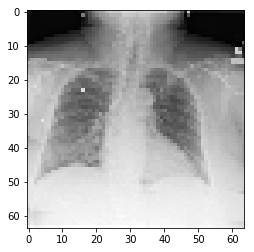

In [10]:
sample_img = sample[0][1].squeeze().numpy()
plt.imshow(sample_img, cmap = 'gray')

### Train loop

In [11]:
def train_model(model, dataloader, optimizer, loss_fn, num_epochs = 10, verbose = False):
    acc_dict = {'train':[],'validate':[]}
    loss_dict = {'train':[],'validate':[]}
    best_acc = 0
    phases = ['train','validate']
    since = time.time()
    for i in range(num_epochs):
        print('Epoch: {}/{}'.format(i, num_epochs-1))
        print('-'*10)
        for p in phases:
            running_correct = 0
            running_loss = 0
            running_total = 0
            if p == 'train':
                model.train(True)
            else:
                model.train(False)
                
            for data in dataloader[p]:
                optimizer.zero_grad()
                image = data[0].to(device)
                label = data[1].to(device)
                output = model(image)
                loss = loss_fn(output, label)
                _, preds = torch.max(output, dim = 1)
                num_imgs = image.size()[0]
                running_correct += torch.sum(preds ==label).item()
                running_loss += loss.item()*num_imgs
                running_total += num_imgs
                if p== 'train':
                    loss.backward()
                    optimizer.step()
            epoch_acc = float(running_correct/running_total)
            epoch_loss = float(running_loss/running_total)
            if verbose or (i%10 == 0):
                print('Phase:{}, epoch loss: {:.4f} Acc: {:.4f}'.format(p, epoch_loss, epoch_acc))
            
            acc_dict[p].append(epoch_acc)
            loss_dict[p].append(epoch_loss)
            if p == 'validate':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    
    return model, acc_dict, loss_dict

### Evaluate Loop`

In [12]:
def evaluate_model(model, dataloader,loss_fn, phase = 'validate'):
    model.eval()
    running_correct = 0
    running_loss = 0
    running_total = 0
    for data in dataloader[phase]:
        image = data[0].to(device)
        label = data[1].to(device)
        output = model(image)
        loss = loss_fn(output, label)
        _, preds = torch.max(output,dim = 1)
        num_imgs = image.size()[0]
        running_correct += torch.sum(preds ==label).item()
        running_loss += loss.item()*num_imgs
        running_total += num_imgs
    accuracy = float(running_correct/running_total)
    loss = float(running_loss/running_total)
    
    return accuracy, loss

### Now lets build some models

### First some common functions that could be useful to build the model

In [13]:
help(nn.LeakyReLU)

Help on class LeakyReLU in module torch.nn.modules.activation:

class LeakyReLU(torch.nn.modules.module.Module)
 |  LeakyReLU(negative_slope=0.01, inplace=False)
 |  
 |  Applies the element-wise function:
 |  
 |  .. math::
 |      \text{LeakyReLU}(x) = \max(0, x) + \text{negative\_slope} * \min(0, x)
 |  
 |  
 |  or
 |  
 |  .. math::
 |      \text{LeakyRELU}(x) =
 |      \begin{cases}
 |      x, & \text{ if } x \geq 0 \\
 |      \text{negative\_slope} \times x, & \text{ otherwise }
 |      \end{cases}
 |  
 |  Args:
 |      negative_slope: Controls the angle of the negative slope. Default: 1e-2
 |      inplace: can optionally do the operation in-place. Default: ``False``
 |  
 |  Shape:
 |      - Input: :math:`(N, *)` where `*` means, any number of additional
 |        dimensions
 |      - Output: :math:`(N, *)`, same shape as the input
 |  
 |  .. image:: scripts/activation_images/LeakyReLU.png
 |  
 |  Examples::
 |  
 |      >>> m = nn.LeakyReLU(0.1)
 |      >>> input = torch.ra

In [14]:
help(nn.MaxPool2d)

Help on class MaxPool2d in module torch.nn.modules.pooling:

class MaxPool2d(_MaxPoolNd)
 |  MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
 |  
 |  Applies a 2D max pooling over an input signal composed of several input
 |  planes.
 |  
 |  In the simplest case, the output value of the layer with input size :math:`(N, C, H, W)`,
 |  output :math:`(N, C, H_{out}, W_{out})` and :attr:`kernel_size` :math:`(kH, kW)`
 |  can be precisely described as:
 |  
 |  .. math::
 |      \begin{aligned}
 |          out(N_i, C_j, h, w) ={} & \max_{m=0, \ldots, kH-1} \max_{n=0, \ldots, kW-1} \\
 |                                  & \text{input}(N_i, C_j, \text{stride[0]} \times h + m,
 |                                                 \text{stride[1]} \times w + n)
 |      \end{aligned}
 |  
 |  If :attr:`padding` is non-zero, then the input is implicitly zero-padded on both sides
 |  for :attr:`padding` number of points. :attr:`dilation` controls the

In [15]:
help(nn.Conv2d)

Help on class Conv2d in module torch.nn.modules.conv:

class Conv2d(_ConvNd)
 |  Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
 |  
 |  Applies a 2D convolution over an input signal composed of several input
 |  planes.
 |  
 |  In the simplest case, the output value of the layer with input size
 |  :math:`(N, C_{\text{in}}, H, W)` and output :math:`(N, C_{\text{out}}, H_{\text{out}}, W_{\text{out}})`
 |  can be precisely described as:
 |  
 |  .. math::
 |      \text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) +
 |      \sum_{k = 0}^{C_{\text{in}} - 1} \text{weight}(C_{\text{out}_j}, k) \star \text{input}(N_i, k)
 |  
 |  
 |  where :math:`\star` is the valid 2D `cross-correlation`_ operator,
 |  :math:`N` is a batch size, :math:`C` denotes a number of channels,
 |  :math:`H` is a height of input planes in pixels, and :math:`W` is
 |  width in pixels.
 |  
 |  * :attr:`stride` controls the stride for the cross-corr

### Define the model class

In [16]:
class Conv_model(nn.Module):
    def __init__(self, kernel_size = 3):
        super(Conv_model,self).__init__()
        self.conv1 = nn.Conv2d(1,16,kernel_size, padding = 1)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(16,16,kernel_size, padding = 1)
        self.relu2 = nn.ReLU()
        
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride = 2)
        
        self.conv3 = nn.Conv2d(16,32,kernel_size, padding = 1, stride = 1)
        self.relu3 = nn.ReLU()
        
        self.conv4 = nn.Conv2d(32,32,kernel_size, padding = 1, stride = 2)
        self.relu4 = nn.ReLU()
        
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride = 2)
        
        self.conv5 = nn.Conv2d(32,32,kernel_size, padding = 1)
        self.relu5 = nn.ReLU()
        
        self.out_conv = nn.Conv2d(32, 2, kernel_size, padding = 1)
        
    def forward(self,x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.maxpool1(x)
        x = self.relu3(self.conv3(x))
        x = self.relu4(self.conv4(x))
        x = self.maxpool2(x)
        x = self.relu5(self.conv5(x))
        x = self.out_conv(x)
        x = F.adaptive_avg_pool2d(x, (1,1))
    
        return x.view(-1,2)

### Lets Train the model

In [17]:
model = Conv_model().to(device)

In [18]:
cel = nn.CrossEntropyLoss()

In [19]:
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

In [20]:
model, acc_dict, loss_dict = train_model(model, dataloader, optimizer, cel, num_epochs=10, verbose = True)

Epoch: 0/9
----------
Phase:train, epoch loss: 0.6849 Acc: 0.5750
Phase:validate, epoch loss: 0.6855 Acc: 0.5650
Epoch: 1/9
----------
Phase:train, epoch loss: 0.6804 Acc: 0.5783
Phase:validate, epoch loss: 0.6961 Acc: 0.5650
Epoch: 2/9
----------
Phase:train, epoch loss: 0.6871 Acc: 0.5783
Phase:validate, epoch loss: 0.6848 Acc: 0.5650
Epoch: 3/9
----------
Phase:train, epoch loss: 0.6817 Acc: 0.5783
Phase:validate, epoch loss: 0.6821 Acc: 0.5650
Epoch: 4/9
----------
Phase:train, epoch loss: 0.6800 Acc: 0.5783
Phase:validate, epoch loss: 0.6849 Acc: 0.5650
Epoch: 5/9
----------
Phase:train, epoch loss: 0.6813 Acc: 0.5783
Phase:validate, epoch loss: 0.6812 Acc: 0.5650
Epoch: 6/9
----------
Phase:train, epoch loss: 0.6783 Acc: 0.5767
Phase:validate, epoch loss: 0.6792 Acc: 0.6050
Epoch: 7/9
----------
Phase:train, epoch loss: 0.6811 Acc: 0.5833
Phase:validate, epoch loss: 0.6822 Acc: 0.5650
Epoch: 8/9
----------
Phase:train, epoch loss: 0.6822 Acc: 0.5767
Phase:validate, epoch loss: 0.

### Now lets evaluate the model

In [21]:
acc, loss = evaluate_model(model, dataloader,cel,phase = 'test')

In [22]:
acc

0.575

In [23]:
loss

0.6775046396255493